# Exploring a neural dataset

Revealing the latent structure of fMRI responses to natural scenes

Analyzing the Natural Scenes dataset reveals high-dimensional latent
structure in neural responses.

In [2]:
%pip install git+https://github.com/BonnerLab/ccn-tutorial.git

In [3]:
from pathlib import Path
import requests
import typing
import warnings

from loguru import logger
import numpy as np
import pandas as pd
import xarray as xr
import nibabel as nib
import nilearn.plotting
from PIL import Image
from sklearn.preprocessing import MinMaxScaler
from sklearn.decomposition import PCA, NMF
from umap import UMAP

import matplotlib as mpl
from mpl_toolkits.axes_grid1 import ImageGrid
from matplotlib import pyplot as plt
from matplotlib_inline.backend_inline import set_matplotlib_formats
from matplotlib.offsetbox import OffsetImage, AnnotationBbox
import seaborn as sns
from IPython.display import display

from utilities.brain import (
    load_dataset,
    average_data_across_repetitions,
    load_stimuli,
    plot_brain_map,
)


In [4]:
%matplotlib inline

sns.set_theme(
    context="notebook",
    style="white",
    palette="deep",
)
set_matplotlib_formats("svg")

pd.set_option("display.max_rows", 5)
pd.set_option("display.max_columns", 10)
pd.set_option("display.precision", 3)
pd.set_option("display.show_dimensions", False)

xr.set_options(display_max_rows=3, display_expand_data=False)

warnings.filterwarnings("ignore")

In [5]:
random_state = 0
rng = np.random.default_rng(seed=random_state)


## The Natural Scenes fMRI Dataset (NSD)

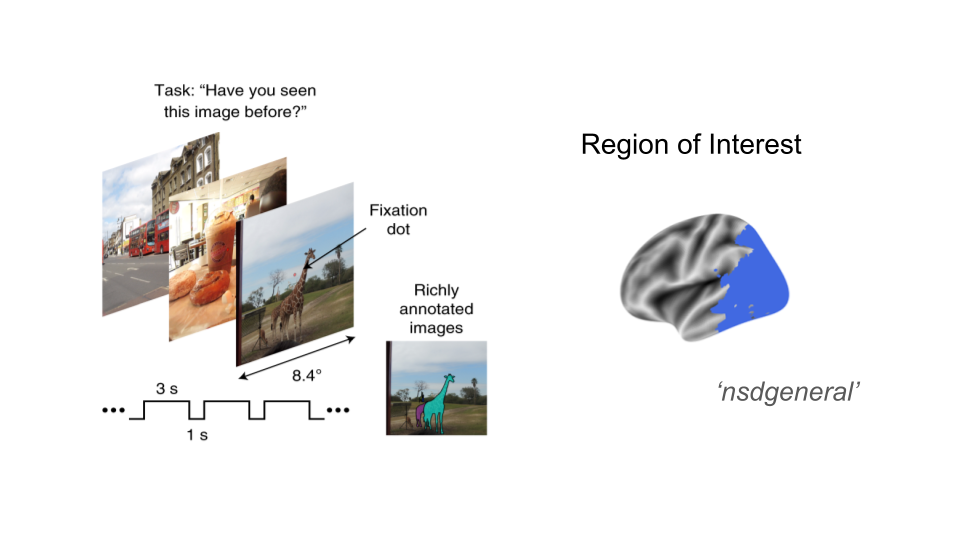

NSD is the largest fMRI dataset on human vision, with 7T fMRI responses
(1.8mm isotropic voxels) obtained from 8 adult participants. The
experiment involved a continuous recognition task while participants
observed natural scene images from the Microsoft Common Objects in
Context (COCO) database (Lin et al., 2014).

Let’s load the dataset. This data contains neural responses to 872
images from ~15,000 voxels reliably modulated by the visual stimuli
during the NSD experiment.

In [6]:
data = average_data_across_repetitions(load_dataset(subject=0, roi="general"))

display(data)


<xarray.DataArray 'fMRI betas' (presentation: 700, neuroid: 15724)>
0.4915 0.2473 0.08592 0.05828 -0.1315 ... -0.2126 -0.6315 -0.5751 -0.5354
Coordinates: (3/4)
 x (neuroid) uint8 12 12 12 12 12 12 12 ... 71 72 72 72 72 72 72
 y (neuroid) uint8 21 22 22 22 22 22 23 ... 34 29 29 30 30 30 31
 ... ...
 stimulus_id (presentation) object 'image02950' ... 'image72948'
Dimensions without coordinates: presentation, neuroid
Attributes: (3/8)
 resolution: 1pt8mm
 preprocessing: fithrf_GLMdenoise_RR
 ... ...
 postprocessing: averaged across first two repetitions xarray.DataArray 'fMRI betas' presentation : 700 neuroid : 15724 0.4915 0.2473 0.08592 0.05828 ... -0.2126 -0.6315 -0.5751 -0.5354 array([[ 0.4915219 , 0.24733381, 0.08592446, ..., -0.366651 ,
 0.30723202, 0.43520752],
 [ 0.1664538 , -0.10728736, 0.35630295, ..., 0.8608913 ,
 0.03464809, 0.11020081],
 [ 1.0357349 , 0.77598304, 0.35813144, ..., 0.2419075 ,
 0.81557286, 0.38667244],
 ...,
 [-0.05812129, -0.4539395 , 0.41060364, ..., 0.5738151 ,
 -0.718189 , -0.638827 ],
 [-0.00340644, -1.0050421 , 0.7278904 , ..., 0.580743 ,
 -0.50856245, -0.2727615 ],
 [-1.2668517 , -1.4769105 , -0.3562023 , ..., -0.63146234,
 -0.575121 , -0.5354325 ]], dtype=float32) Coordinates: (4) x (neuroid) uint8 12 12 12 12 12 ... 72 72 72 72 72 array([12, 12, 12, ..., 72, 72, 72], dtype=uint8) y (neuroid) uint8 21 22 22 22 22 ... 29 30 30 30 31 array([21, 22, 22, ..., 30, 30, 31], dtype=uint8) z (neuroid) uint8 47 45 46 47 48 ... 46 45 46 49 49 array([47, 45, 46, ..., 46, 49, 49], dtype=uint8) stimulus_id (presentation) object 'image02950' ... 'image72948' array(['image02950', 'image02990', 'image03049', 'image03077',
 'image03146', 'image03157', 'image03164', 'image03171',
 'image03181', 'image03386', 'image03434', 'image03449',
 'image03489', 'image03626', 'image03682', 'image03687',
 'image03729', 'image03809', 'image03842', 'image03847',
 'image03856', 'image03913', 'image03951', 'image04051',
 'image04058', 'image04129', 'image04156', 'image04249',
 'image04423', 'image04436', 'image04667', 'image04690',
 'image04768', 'image04786', 'image04835', 'image04892',
 'image04930', 'image05034', 'image05106', 'image05204',
 'image05301', 'image05338', 'image05459', 'image05542',
 'image05583', 'image05602', 'image05714', 'image06199',
 'image06222', 'image06431', 'image06444', 'image06489',
 'image06514', 'image06521', 'image06558', 'image06801',
 'image07007', 'image07039', 'image07120', 'image07207',
 'image07366', 'image07418', 'image07480', 'image07654',
 'image07840', 'image07859', 'image07944', 'image07948',
 'image08006', 'image08109', 'image08204', 'image08225',
 'image08394', 'image08415', 'image08435', 'image08465',
 'image08509', 'image08646', 'image08807', 'image08843',
...
 'image64615', 'image64621', 'image64867', 'image64880',
 'image65010', 'image65148', 'image65253', 'image65267',
 'image65376', 'image65445', 'image65769', 'image65799',
 'image65821', 'image65872', 'image65920', 'image65943',
 'image66004', 'image66216', 'image66278', 'image66330',
 'image66464', 'image66489', 'image66580', 'image66773',
 'image66836', 'image66946', 'image66976', 'image67045',
 'image67113', 'image67204', 'image67237', 'image67295',
 'image67742', 'image67802', 'image67829', 'image68168',
 'image68278', 'image68339', 'image68418', 'image68471',
 'image68741', 'image68814', 'image68842', 'image68858',
 'image68897', 'image69007', 'image69130', 'image69214',
 'image69240', 'image69502', 'image69614', 'image69839',
 'image69854', 'image70075', 'image70095', 'image70193',
 'image70232', 'image70335', 'image70360', 'image70427',
 'image70505', 'image71229', 'image71232', 'image71241',
 'image71410', 'image71450', 'image71753', 'image71894',
 'image72015', 'image72080', 'image72209', 'image72312',
 'image72510', 'image72605', 'image72719', 'image72948'],
 dtype=object) Indexes: (0) Attributes: (8) resolution : 1pt8mm preprocessing : fithrf_GLMdenoise_RR z_score : True roi : general subject : 0 brain shape : [ 81 1

> **Some fMRI preprocessing details**
>
> We utilized the NSD single-trial betas, preprocessed in 1.8 mm
> volumetric space and denoised using the GLMdenoise technique (version
> 3;“betas_fithrf_GLMdenoise_RR”). The betas were converted to Z-scores
> within each scanning session and averaged across repetitions for each
> stimulus.

In [7]:
def view_stimuli(stimuli: xr.DataArray, *, n: int = 10) -> None:
    fig = plt.figure(figsize=(15, 5))
    image_grid = ImageGrid(
        fig=fig,
        rect=(1, 1, 1),
        nrows_ncols=(1, n),
        share_all=True,
    )
    for i_image in range(n):
        image_grid[i_image].imshow(stimuli[i_image])
        image_grid[i_image].axis("off")
    fig.show()


stimuli = load_stimuli()
view_stimuli(stimuli)


In [8]:
def view_images_as_scatterplot(
    x: np.ndarray, y: np.ndarray, *, stimuli: xr.DataArray
) -> None:
    fig, ax = plt.subplots(figsize=(20, 20))
    for i_stimulus in range(len(stimuli)):
        image_box = OffsetImage(stimuli[i_stimulus].values, zoom=0.5)
        image_box.image.axes = ax

        ab = AnnotationBbox(
            image_box,
            xy=(x[i_stimulus], y[i_stimulus]),
            xycoords="data",
            frameon=False,
            pad=0,
        )
        ax.add_artist(ab)

    ax.set_xlim([x.min(), x.max()])
    ax.set_ylim([y.min(), y.max()])
    ax.axis("off")
    fig.show()


def view_images_at_poles(
    x: np.ndarray,
    *,
    stimuli: xr.DataArray,
    n_images_per_pole: int = 5,
    label: str | None = None,
) -> None:
    indices = np.argsort(x, axis=0)

    fig = plt.figure(figsize=(15, 5))
    image_grid = ImageGrid(
        fig=fig,
        rect=(1, 1, 1),
        nrows_ncols=(1, 2 * n_images_per_pole + 1),
        share_all=True,
    )
    for i_image in range(n_images_per_pole):
        image_grid[i_image].imshow(stimuli[indices[i_image]])
        image_grid[i_image].axis("off")
        image_grid[-i_image - 1].imshow(stimuli[indices[-i_image - 1]])
        image_grid[-i_image - 1].axis("off")

    for ax in image_grid:
        ax.axis("off")

    if label is not None:
        ax = image_grid[n_images_per_pole]
        ax.text(
            0.5,
            0.5,
            label,
            horizontalalignment="center",
            verticalalignment="center",
            transform=ax.transAxes,
        )
    fig.show()


### Visualizing principal components

In [9]:
pca = PCA()
pca.fit(data)

data_pca = pca.transform(data)

for rank in [1, 2, 3, 10, 50, 100]:
    view_images_at_poles(data_pca[:, rank - 1], stimuli=stimuli, label=f"rank {rank}")


In [10]:
view_images_as_scatterplot(data_pca[:, 0], data_pca[:, 1], stimuli=stimuli)


In [11]:
def view_eigenvector(
    eigenvector: np.ndarray,
    *,
    data: xr.DataArray,
    label: str | None = None,
) -> None:
    fig = plot_brain_map(
        data=xr.DataArray(
            name="eigenvector",
            data=eigenvector,
            dims=("neuroid",),
            coords={
                coord: ("neuroid", data[coord].values) for coord in ("x", "y", "z")
            },
            attrs=data.attrs,
        ),
        subject=data.attrs["subject"],
        title=label,
    )
    fig.show()


# for rank in (1, 2, 5, 10, 50):
#     view_eigenvector(pca.components_[rank - 1, ...], data=data, label=f"rank {rank}")


### The neural eigenspectrum

Let’s plot the eigenspectrum of the neural responses!

In [12]:
def view_eigenspectrum(pca: PCA, *, log: bool = False) -> None:
    eigenvalues = pd.DataFrame(pca.explained_variance_, columns=["eigenvalue"]).assign(
        rank=1 + np.arange(pca.n_components_)
    )

    fig, ax = plt.subplots(figsize=(6, 6))
    sns.lineplot(
        ax=ax,
        data=eigenvalues,
        x="rank",
        y="eigenvalue",
    )
    sns.despine(ax=ax)
    if log:
        ax.set_xscale("log")
        ax.set_yscale("log")
        ax.set_ylim(bottom=1e-2)
    fig.show()


view_eigenspectrum(pca)


On this plot, there appears to be negligible variance after about rank
20. It is a common practice to drop the rest of higher-rank PCs.
However, before doing so, let’s try visualizing the spectrum on a
logarithmic scale for both axes:

In [13]:
view_eigenspectrum(pca, log=True)


On a log-log scale, the spectrum shows no obvious discontinuity! This
suggests that the neural population code has a scale-free structure and
its latent dimensionality is likely higher than 20!

What kind of structure is this? We observe that the spectrum is
approximately linear on this log-log scale, suggesting that the
eigenvalues obey a power law:

$$\log{\lambda_\text{rank}} \approx \alpha \log{\left( \text{rank} \right)} + c \implies \lambda_\text{rank} \propto \left( \text{rank} \right)^\alpha$$

#### Power laws

A power law is a relationship of the form $f(x) \propto x^{\alpha}$,
where $\alpha$ is termed the *index* of the power law, or the *power law
exponent*.

Power laws are ubiquitious in nature, arising in all sorts of systems:

-   wealth distribution (Pareto principle)
-   word frequencies in natural language (Zipf’s law)
-   ferromagnetism (Ising model)

Power laws are *scale-free*: $f(kx) \propto f(x)$.

-   bonus: phase transitions at critical power-law exponent
    -   e.g. Curie temperature of ferromagnetic substances
-   bonus: self-organizing systems

### Some nonlinear methods

#### Nonnegative matrix factorization (NMF)

In [14]:
scaler = MinMaxScaler()
scaler.fit(data)

nmf = NMF(n_components=2, random_state=random_state)
data_nmf = nmf.fit_transform(scaler.transform(data))

view_images_as_scatterplot(data_nmf[:, 0], data_nmf[:, 1], stimuli=stimuli)


#### Uniform Manifold Approximation & Projection (UMAP)

In [15]:
umap = UMAP(n_components=2, metric="euclidean", random_state=random_state)
data_umap = umap.fit_transform(data)

view_images_as_scatterplot(data_umap[:, 0], data_umap[:, 1], stimuli=stimuli)
